In [2]:
!apt-get install -y software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update
!apt-get install -y fenics

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Repository: 'deb https://ppa.launchpadcontent.net/fenics-packages/fenics/ubuntu/ jammy main'
Description:
This PPA provides packages for the FEniCS project (https://fenicsproject.org).
More info: https://launchpad.net/~fenics-packages/+archive/ubuntu/fenics
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding key to /etc/apt/trusted.gpg.d/fenics-packages-ubuntu-fenics.gpg with fingerprint 6C1DA1C0EC4B649179C1C7437C3297BD11D01687
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://archive.ubuntu.com/ubuntu j

In [3]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2025-03-23 15:38:43--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-03-23 15:38:44 (43.7 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33a7ab/releases/pybi

In [8]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
from dolfin import File

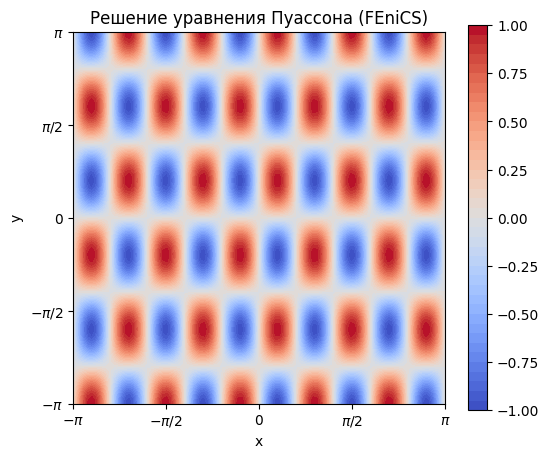

In [13]:
k, m = 10, 5
mesh_parts = 99

# сетка на квадрате [0, pi] x [0, pi]
mesh = RectangleMesh(Point(0, 0), Point(np.pi, np.pi), mesh_parts, mesh_parts)

# функциональное пространство
V = FunctionSpace(mesh, "CG", 1)

# граничные условия
ub = Expression("sin(k*x[0]) * cos(m*x[1])", degree=2, k=k, m=m)
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, ub, boundary)

# вариационная постановка
u = TrialFunction(V)
v = TestFunction(V)
f = Expression("(pow(k,2) + pow(m,2)) * sin(k*x[0]) * cos(m*x[1])", degree=2, k=k, m=m)
a = dot(grad(u), grad(v)) * dx
L = f * v * dx

u = Function(V)
solve(a == L, u, bc)

plt.figure(figsize=(6, 5))
p = plot(u, cmap="coolwarm")
plt.colorbar(p)

# Настройка визуала
tick_labels = [r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"]
plt.xticks(np.linspace(0, np.pi, 5), labels=tick_labels)
plt.yticks(np.linspace(0, np.pi, 5), labels=tick_labels)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Решение уравнения Пуассона (FEniCS)")


u_values = u.compute_vertex_values(mesh).reshape((mesh_parts + 1, mesh_parts + 1)) # u.vector().get_local()
np.save(f"FEniCS_{k}_{m}.npy", u_values)

# save_file = File(f"FEniCS_{k}_{m}.pvd")
# save_file << u

In [14]:
k_values = [1, 2, 10]
m_values = [1, 3, 5]
mesh_sizes = [20, 40, 80]

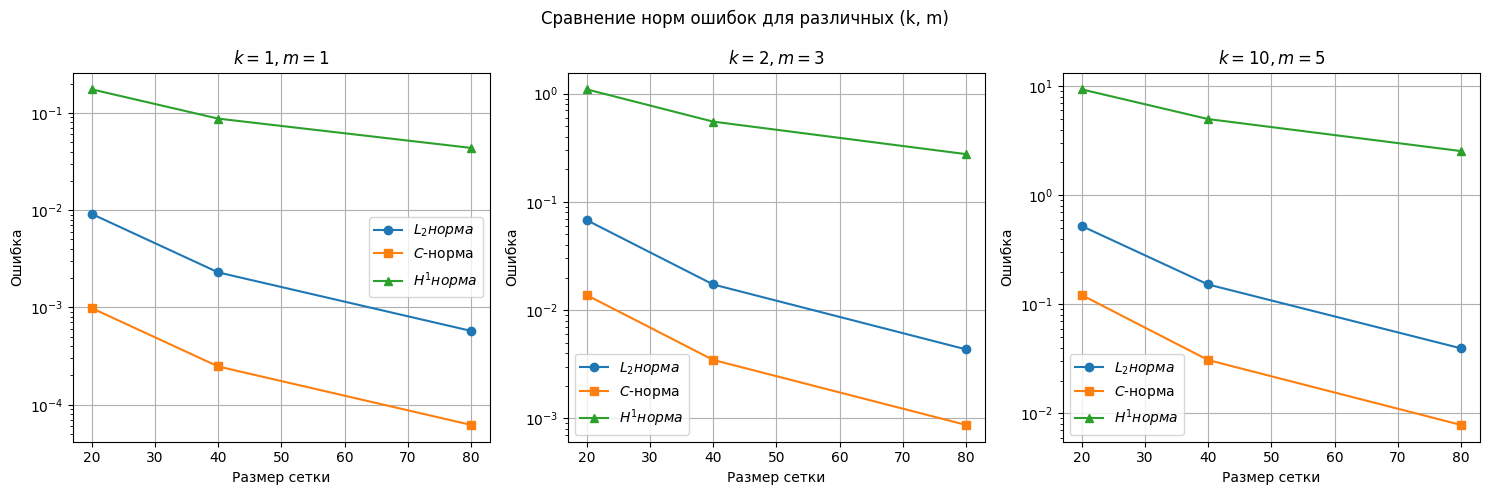

In [19]:
# Готовим фигуру для графиков
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (k, m) in enumerate(zip(k_values, m_values)):
    l2_errors = []
    c_errors = []
    h1_errors = []

    for mesh_size in mesh_sizes:
        # сетка на квадрате [0, pi] x [0, pi]
        mesh = RectangleMesh(Point(0, 0), Point(np.pi, np.pi), mesh_size, mesh_size)

        # Функциональное пространство
        V = FunctionSpace(mesh, "P", 1)

        # Граничные условия
        u_exact = Expression("sin(k*x[0]) * cos(m*x[1])", degree=6, k=k, m=m)
        bc = DirichletBC(V, u_exact, "on_boundary")

        # Вариационная постановка
        u = TrialFunction(V)
        v = TestFunction(V)
        f = Expression("(pow(k,2) + pow(m,2)) * sin(k*x[0]) * cos(m*x[1])", degree=6, k=k, m=m)
        a = dot(grad(u), grad(v)) * dx
        L = f * v * dx

        # Решение задачи
        u_num = Function(V)
        solve(a == L, u_num, bc)

        # Вычисление ошибок
        l2_error = errornorm(u_exact, u_num, norm_type="L2", degree_rise=3)
        c_error = np.max(np.abs(u_num.compute_vertex_values(mesh) - u_exact.compute_vertex_values(mesh)))
        h1_error = errornorm(u_exact, u_num, norm_type="H1", degree_rise=3)

        l2_errors.append(l2_error)
        c_errors.append(c_error)
        h1_errors.append(h1_error)

    # Построение графика
    ax = axes[i]
    ax.plot(mesh_sizes, l2_errors, marker='o', label=r"$L_2 норма$")
    ax.plot(mesh_sizes, c_errors, marker='s', label=r"$C$-норма")
    ax.plot(mesh_sizes, h1_errors, marker='^', label=r"$H^1 норма$")
    #ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Размер сетки")
    ax.set_ylabel("Ошибка")
    ax.set_title(f"$k={k}, m={m}$")
    ax.legend()
    ax.grid()

plt.suptitle("Сравнение норм ошибок для различных (k, m)")
plt.tight_layout()
plt.show()

In [ ]:
for i, k in enumerate(k_values):
    for j, mesh_size in enumerate(mesh_parts):
        m = m_values[i]

        # сетка на квадрате [0, pi] x [0, pi]
        mesh = RectangleMesh(Point(0, 0), Point(np.pi, np.pi), mesh_size, mesh_size)

        # функциональное пространство
        V = FunctionSpace(mesh, "P", 1)

        # граничные условия
        ub = Expression("sin(k*x[0]) * cos(m*x[1])", degree=2, k=k, m=m)
        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(V, ub, boundary)

        # вариационная постановка
        u = TrialFunction(V)
        v = TestFunction(V)
        f = Expression("(pow(k,2) + pow(m,2)) * sin(k*x[0]) * cos(m*x[1])", degree=2, k=k, m=m)
        a = dot(grad(u), grad(v)) * dx
        L = f * v * dx

        u = Function(V)
        solve(a == L, u, bc)


        plt.figure(figsize=(6, 5))
        p = plot(u, cmap="coolwarm")
        plt.colorbar(p)

        # Настройка визуала
        tick_labels = [r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"]
        plt.xticks(np.linspace(0, np.pi, 5), labels=tick_labels)
        plt.yticks(np.linspace(0, np.pi, 5), labels=tick_labels)

        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Решение уравнения Пуассона (FEniCS)")

In [ ]:
fig, axes = plt.subplots(len(k_values), len(mesh_parts), figsize=(10, 10))
tick_labels = [r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"]

for i, k in enumerate(k_values):
    for j, mesh_size in enumerate(mesh_parts):
        m = m_values[i]

        # сетка на квадрате [0, pi] x [0, pi]
        mesh = RectangleMesh(Point(0, 0), Point(np.pi, np.pi), mesh_size, mesh_size)

        # функциональное пространство
        V = FunctionSpace(mesh, "P", 1)

        # граничные условия
        ub = Expression("sin(k*x[0]) * cos(m*x[1])", degree=2, k=k, m=m)
        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(V, ub, boundary)

        # вариационная постановка
        u = TrialFunction(V)
        v = TestFunction(V)
        f = Expression("(pow(k,2) + pow(m,2)) * sin(k*x[0]) * cos(m*x[1])", degree=2, k=k, m=m)
        a = dot(grad(u), grad(v)) * dx
        L = f * v * dx

        u = Function(V)
        solve(a == L, u, bc)


        # Визуализация
        u_values = u.compute_vertex_values(mesh).reshape((mesh_size + 1, mesh_size + 1))
        ax = axes[i, j]
        im = ax.imshow(u_values, extent=[0, np.pi, 0, np.pi], cmap='coolwarm')
        ax.set_title(f"k={k}, m={m}, N={mesh_size}")

        # ax.set_xticklabels(tick_labels)
        # ax.set_yticklabels(tick_labels)

        fig.colorbar(im, ax=ax)


plt.tight_layout()
plt.show()